<header>
    <h1>CA4010 - Data warehousing and Data mining</h1>
    <h2>Continuous assessment project</h2>
</header>
<p>
    For this project, we want to predict if a project submitted to 
    <a href="https://www.indiegogo.com">indiegogo.com</a> will or will not be funded.
    For this purpose, we'll use a
    <a href="https://www.kaggle.com/kingburrito666/indiegogo-project-statistics/data">
    dataset from kaggle containing one year of indiegogo projects.</a>
     The version used here is the version cleaned in part 1 and 2.
</p>
<p>
    This notebook will decribe and show what how clustering can help us to detect outliers.
</p>

<h2>Clustering the whole dataset</h2>
<p>
    In this part, we'll run a clustering on the whole dataset, without outliers removal.
</p>

In [23]:
import pandas as pd
from time import time
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.decomposition import PCA
import copy
%matplotlib inline

In [24]:
indiegogo = pd.read_csv("indiegogo_cleaned_dataset.tsv", sep='\t')
base_dataset = copy.copy(indiegogo)

<p>
    First, let's normalize our data using <b>z score</b>
</p>

In [25]:
cols  = ["collected_percentage", "target_amount", "pledges_count", "tagline_len", "title_len"]
for col in cols:
    indiegogo[col] = (indiegogo[col] - indiegogo[col].mean())/indiegogo[col].std(ddof=0)

<p>
    Now, as we have mixed attributes (continuous and categorical) we will perform a <b>one hot encoding</b> on the 2 non binary categorical attributes that we have.
</p>

In [26]:
indiegogo = pd.get_dummies(indiegogo, prefix=['category_slug', 'currency_code'])

<p>
    To have a better understanding of the clustering performed, we'll use the Principal Component Analysis (aka PCA) to achieve a <b>2-D dimensionality reduction</b> and be able to plot the result in a way we can interpret easily.
</p>

In [27]:
reduced_data = PCA(n_components=2).fit_transform(indiegogo)
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=10)
kmeans.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

<p>
    Now, we draw the background color of each cluster
</p>

In [28]:
# Code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)

<p>
    Now that we have background colors, let's plot all the projects from our dataset.
</p>

([], <a list of 0 Text yticklabel objects>)

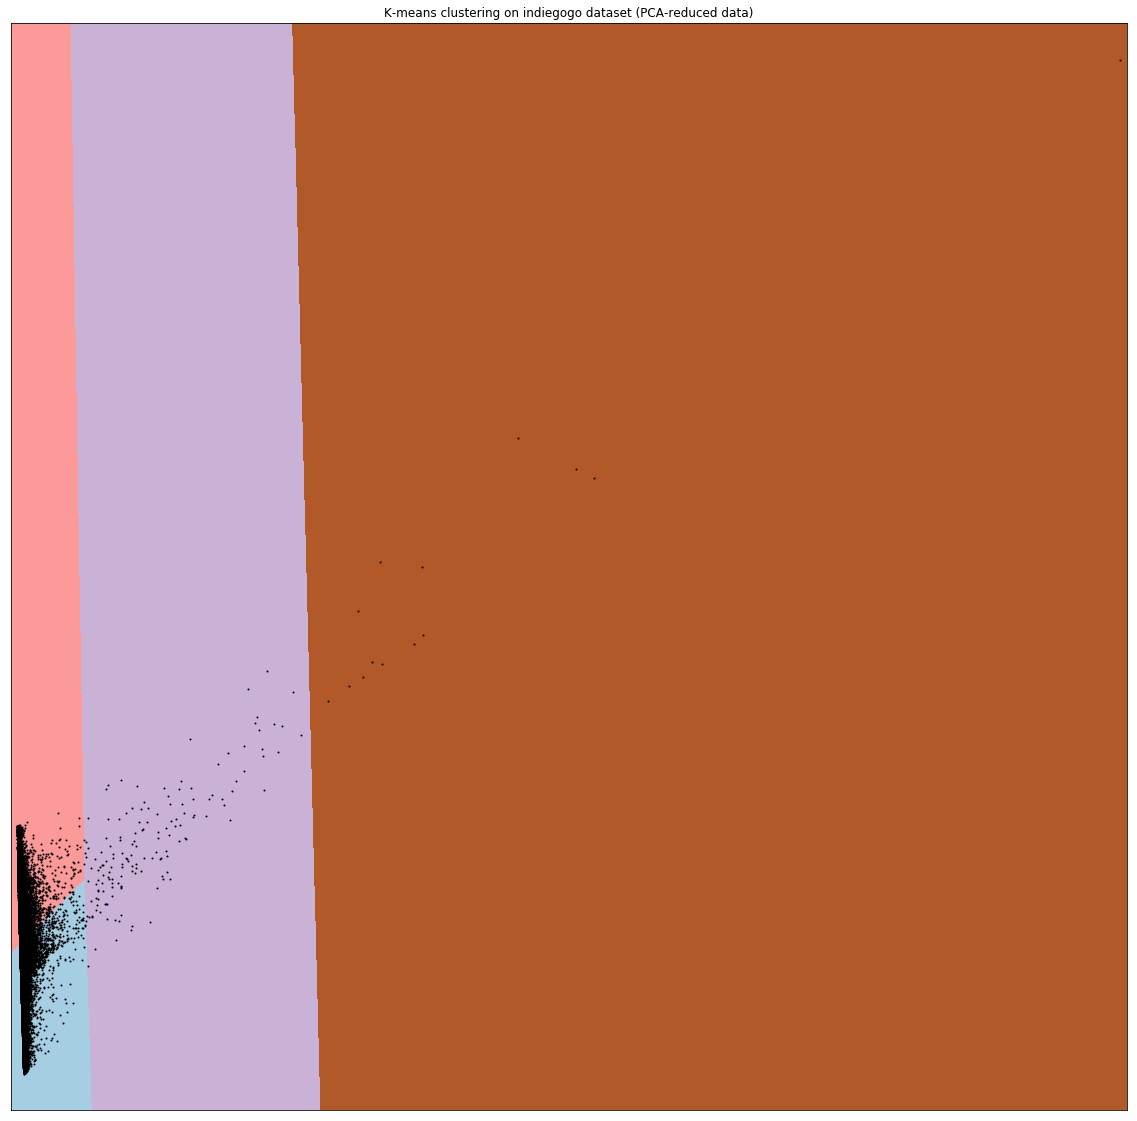

In [29]:
plt.figure(1, figsize=(20, 20))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.title('K-means clustering on indiegogo dataset (PCA-reduced data)')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

<p>Our dataset has lot of values in the low left of the graph (representing the common not so successful projects) and a long tail going to the upper right (representing the popular projects. One outiler is very distinct at the top right of the graph. This is the project for ubuntu EDGE we've seen before in our analysis. We can't remove the tail as they are significant project with high collected percentages or high pledges count. We'll have to be careful ine the choices we'll made for our algorithm as our dataset contains extreme values</p>

In [32]:
base_dataset.target_amount.max()

8013036.5079365075

In [31]:
base_dataset = base_dataset[base_dataset.target_amount != 32035540.0]

In [33]:
base_dataset.to_csv("indiegogo_cleaned_dataset.tsv", sep='\t', index=False)